<a href="https://colab.research.google.com/github/Sukhman723/my_projects/blob/main/google_colab/Titanic_c_RegressorForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load and Process data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd /content/drive/MyDrive/Code_files_and_data/data/titanic_data/

/content/drive/MyDrive/Code_files_and_data/data/titanic_data


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
# load the data
train_full = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#train_full.head()
# separete labels from features
y = train_full['Survived']
# drop following columns
X = train_full.drop(['Survived','Cabin'], axis=1)

# X = train_full.drop(columns='Cabin') 
# train-valid split
X_train,X_valid,y_train,y_valid = train_test_split(X,y,
                 train_size=0.8,
                 test_size=0.2,
                 random_state=0)

X.head()
for cname in X.columns:
  if X[cname].dtype == "object":
    print({cname: X_train[cname].nunique()})
  
# prepare for preprocessing
# one hot-encode above columns only sex, Embarked
# only choose column with less than 10 cardinality (number of unique element)
categorical_cols = [cname for cname in X.columns 
      if X[cname].nunique() < 10 and 
         X[cname].dtype == "object"]

print('\n\n',categorical_cols)

numerical_cols = [cname for cname in X.columns 
                        if X[cname].dtype in ['int','float64']]

print(numerical_cols)

# concatenate all the cols
my_cols = numerical_cols + categorical_cols
X_train = X_train[my_cols] # training data
X_valid = X_valid[my_cols] # validation data



{'Name': 712}
{'Sex': 2}
{'Ticket': 569}
{'Embarked': 3}


 ['Sex', 'Embarked']
['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [9]:
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [10]:
print(X['Ticket'].dtype)

object


# Random Forest regressor

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# write your pipeline
# pipeline(step=[step1, step2])
# there are some missing values and categorical cols so i need:
# substitute missing value with mean of that col, median of that col, most frequent value in that col, constant
numerical_transformer = SimpleImputer(strategy='constant') # edit later on

# one-hot encode categorical cols
categorical_transformer = Pipeline(steps=[
                                          ('imputer', SimpleImputer(strategy='most_frequent')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# bundle all the transformers together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat',categorical_transformer, categorical_cols)
    ])

In [12]:
# define my model
my_pipeline = Pipeline(steps=[
      ('preprocessor',preprocessor), 
      ('model', RandomForestRegressor(n_estimators=100,random_state=0))
])

In [13]:
my_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['PassengerId', 'Pclass',
                                                   'Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('model', RandomForestRegressor(random_state=0))])

In [14]:
# fit and predict using above pipeline
my_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['PassengerId', 'Pclass',
                                                   'Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('model', RandomForestRegressor(random_state=0))])

In [15]:
# predict on training data
from sklearn.metrics import mean_absolute_error
preds_train = my_pipeline.predict(X_train)
mean_absolute_error(y_train, preds_train)

0.09839887640449438

In [16]:
# validate on validation data
preds = my_pipeline.predict(X_valid)

In [17]:
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 0.24083798882681565


In [18]:
# don't predict on test set cause i don't yet preprocessed it
preds_test = my_pipeline.predict(test)

In [19]:
# Save test predictions to file
output = pd.DataFrame({
                       'PassangerID': X_valid.PassengerId,
                       'Sex': X_valid.Sex,
                       'survived': preds})
output.to_csv('submission.csv', index=False)

In [20]:
predicted_db = pd.read_csv('submission.csv')

In [21]:
predicted_db.head()

,PassangerID,Sex,survived
0,496,male,0.35
1,649,male,0.00
2,279,male,0.33
3,32,female,0.60
4,256,female,0.21


#Visualize

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


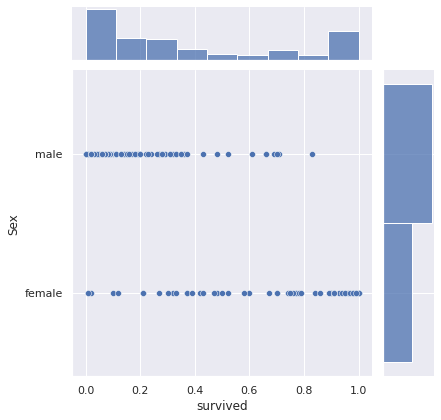

In [25]:
sns.jointplot(predicted_db['survived'], predicted_db['Sex'])

In [ ]:
#import matplotlib.pyplot as plt 
#plt.bar(X_valid['Sex'],y_valid)

In [26]:
train_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


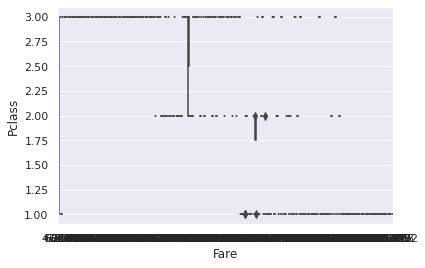

In [27]:
sns.boxplot(train_full['Fare'],train_full['Pclass'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


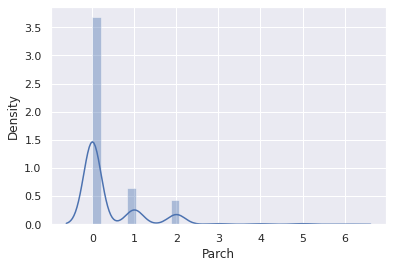

In [28]:
sns.distplot(train_full['Parch'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


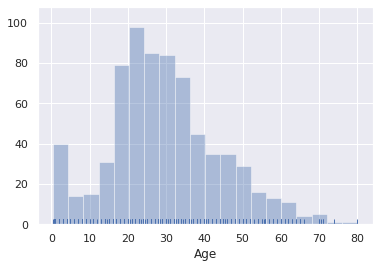

In [29]:
sns.distplot(train_full['Age'], kde=False, rug=True)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


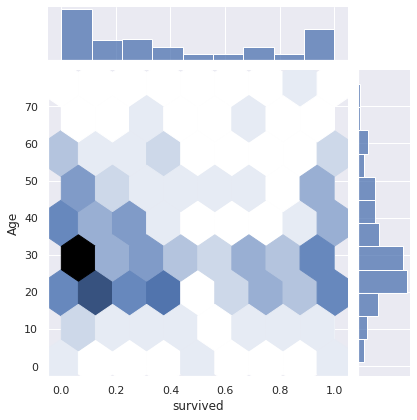

In [31]:
sns.jointplot(predicted_db['survived'], test['Age'], kind='hex')